In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import stock_project_functions_SAVE as spf
import model_functions_SAVE as mf
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,matthews_corrcoef
stock_df=pd.read_csv('All_Stock_Data_TTM_RS_2016-2019.csv')
etf_df=pd.read_csv('All_ETF_Data_TTM_RS_2016-2019.csv')
model = XGBClassifier(colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.8, random_state=42)

# Objective: Build a classification model that predicts whether a stock will be profitable for some holding period.  The intention will be to use the predicted probability from the model to rank stocks and pick the ones with the highest ranking.

# Targets
### -Invest_20: Binary label that is True if the stock has increased in price from the investment date to 20 days later.
### -Performance_Label: Multiclass label that is based on the quantiles of the positive and negative percent changes.
#### &emsp;-Class 0: Strong Down
#### &emsp;-Class 1: Weak Down
#### &emsp;-Class 2: Week UP
#### &emsp;-Class 0: Strong Up


# 2016-2019 Stocks

In [3]:
stock_df

,Unnamed: 0,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Month,...,VOO_Close_pct_change_lag13,VOO_Close_pct_change_lag14,VOO_Close_pct_change_lag15,VOO_Close_pct_change_lag16,VOO_Close_pct_change_lag17,VOO_Close_pct_change_lag18,VOO_Close_pct_change_lag19,RS_Slope_1,RS_Slope_2,RS_Slope_3
0,0,2016-02-01,34.845894,35.386720,34.500886,35.144279,2666200,0.0,0.0,2,...,0.008296,0.000114,-0.010626,-0.024356,-0.012673,0.001791,-0.014016,-0.003746,-0.002295,0.000343
1,316,2016-02-01,57.197569,57.528815,56.904543,56.955505,5985600,0.0,0.0,2,...,0.008296,0.000114,-0.010626,-0.024356,-0.012673,0.001791,-0.014016,0.003562,-0.001935,0.001596
2,287,2016-02-01,61.599998,62.830002,61.439999,61.959999,2667300,0.0,0.0,2,...,0.008296,0.000114,-0.010626,-0.024356,-0.012673,0.001791,-0.014016,-0.005054,-0.005614,-0.031291
3,286,2016-02-01,162.070391,165.000837,160.548645,164.035614,1426000,0.0,0.0,2,...,0.008296,0.000114,-0.010626,-0.024356,-0.012673,0.001791,-0.014016,0.010960,0.002187,-0.004422
4,285,2016-02-01,55.911470,57.468843,55.866198,57.188152,8247800,0.0,0.0,2,...,0.008296,0.000114,-0.010626,-0.024356,-0.012673,0.001791,-0.014016,-0.001365,0.004591,-0.000764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319963,319640,2018-10-18,92.404938,92.950557,91.625478,92.404938,2096900,0.0,0.0,10,...,0.003707,-0.000112,0.002778,-0.002931,-0.001228,-0.003339,-0.000705,0.011621,0.000435,-0.002328
319964,319639,2018-10-18,4.890000,5.110000,4.830000,4.870000,2186600,0.0,0.0,10,...,0.003707,-0.000112,0.002778,-0.002931,-0.001228,-0.003339,-0.000705,0.031183,-0.008808,0.022502
319965,319725,2018-10-18,149.149994,149.509995,143.910004,145.050003,976700,0.0,0.0,10,...,0.003707,-0.000112,0.002778,-0.002931,-0.001228,-0.003339,-0.000705,0.001642,0.000448,-0.000096
319966,319607,2018-10-18,74.830316,75.361204,73.654774,74.046623,6191869,0.0,0.0,10,...,0.003707,-0.000112,0.002778,-0.002931,-0.001228,-0.003339,-0.000705,-0.005646,-0.002023,0.001655


In [3]:
from sklearn.impute import SimpleImputer
def fit_multi_classifier(train,test,features, max_depth=5, subsample=0.8, gamma=0.1, n_estimators=200, learning_rate=0.1, colsample_bytree=0.8):
    X_train, y_train = preprocess_data(train, features)
    X_test, y_test = preprocess_data(test, features)
    class_weights = {0: 1, 1: 1, 2: 1, 3: 1}  # Adjust these values as needed
    model = XGBClassifier(
    max_depth=max_depth,
    n_estimators= n_estimators,
    learning_rate=learning_rate,
    gamma=gamma,
    colsample_bytree=colsample_bytree,
    subsample=subsample,
    
    scale_pos_weight=class_weights[0],  # Focus on Class 0
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

    model.fit(X_train, y_train)
    
    # 3. Make predictions on test set
    y_pred_proba = model.predict_proba(X_test)
    y_pred=model.predict(X_test)
    # 4. Evaluate the model
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    # 5. Feature Importance
    feature_importance = model.feature_importances_
    feature_importance_df = pd.DataFrame({'feature': X_train.columns, 'importance': feature_importance})
    feature_importance_df = feature_importance_df.sort_values('importance', ascending=False).reset_index(drop=True)
    print("\nTop 20 Most Important Features:")
    print(feature_importance_df.head(20))
    return model, X_test,y_test,y_pred_proba,y_pred
def get_features(df,ttm=True, rs=True, tickers=True, vwap=True, squeeze=True, close=True,quadratic=False,month=True):
    features=[]
    if rs:
        rs_features=[f'RS_{i}' for i in range(20)]+[col for col in df.columns if 'RS_Slope' in col]+['Correlation','Recent Growth','Recent_Volatility','Volatility']
        features=features+rs_features
    if close:
        
        close_features=[col for col in df.columns if 'Close' in col and 'lag' in col]
        features=features+close_features
    if ttm:    
        ttm_features=[col for col in df.columns if 'TTM' in col and 'lag' in col]
        features=features+ttm_features
    if vwap:
        vwap_features=[col for col in df.columns if 'VWAP' in col and 'lag' in col]
        features=features+vwap_features
    if squeeze:
        squeeze_features=[col for col in df.columns if 'Squeeze' in col and 'lag' in col]
        features=features+squeeze_features
    if quadratic:
        quadratic_features=['Quadratic_R2']+[col for col in df.columns if 'Likely' in col]
        features=features+quadratic_features
    if tickers:
        ticker_features=[col for col in df.columns if 'Ticker_' in col]
        features=features+ticker_features
    if month:
        features=features+['Month']
    features=[col for col in features if 'lag_0' not in col]
    features=[col for col in features if 'lag0' not in col]
    return features
def get_train_test(joined, ticker_dummies=False):
    if ticker_dummies:
        #joined=pd.get_dummies(joined,columns=['Ticker'])
        dummies = pd.get_dummies(joined['Ticker'], prefix='Ticker', drop_first=False)

# Concatenate the dummy variables with the original DataFrame
        joined = pd.concat([joined, dummies], axis=1)
        features = [col for col in joined.columns if 'lag' in col] + ['Month']+[col for col in joined if 'Ticker' in col]
    else:
        features = [col for col in joined.columns if 'lag' in col] + ['Month']
    
    joined.sort_values(by='Date', inplace=True)
    joined=joined.dropna(subset=features)
    # Define the split point (e.g., 70% for training)
    split_point = int(len(joined) * 0.6)
    
    # Split the data into training and testing sets
    train = joined.iloc[:split_point]
    test = joined.iloc[split_point:]
    return joined,train, test
def create_performance_label(df, holding_period):
    # Calculate the percentage change
    pct_change_col = f'Pct_Change_{holding_period}'
    df[pct_change_col] = df['Close'].pct_change(periods=holding_period).shift(-holding_period)
    
    # Calculate quantiles
    q1, q2, q3 = df[pct_change_col].quantile([0.25, 0.5, 0.75])
    
    # Define the performance categories function
    def performance_categories(value):
        if pd.isna(value):
            return np.nan
        elif value <= q1:
            return 0  # Strong Down
        elif q1 < value <= q2:
            return 1  # Slight Down
        elif q2 < value <= q3:
            return 2  # Slight Up
        else:
            return 3  # Strong Up
    
    # Apply the categorization
    df['Performance_Label'] = df[pct_change_col].apply(performance_categories)
    
    return df
# 1. Data Preprocessing
def preprocess_data(df, features):
    # Select features based on the provided list
    X = df[features]
    y = df['Performance_Label']
    
    # Identify datetime columns and convert them to ordinal
    datetime_cols = X.select_dtypes(include=['datetime64']).columns
    
    for col in datetime_cols:
        X[col] = X[col].astype(int) // 10**9  # Convert to Unix timestamp
    
    # Impute missing values
    imputer = SimpleImputer(strategy='mean')
    X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
    
    # Scale features
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    
    return X, y

In [21]:
stock_df[['TTM','Ticker','Weekly_TTM','Date']]
stock_df['Date']=pd.to_datetime(stock_df['Date']).dt.date
etf_df['Date']=pd.to_datetime(etf_df['Date']).dt.date

In [22]:
stock_df=stock_df.dropna()
etf_df.dropna(inplace=True)
stock_df

,Unnamed: 0,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Month,...,VOO_Close_pct_change_lag13,VOO_Close_pct_change_lag14,VOO_Close_pct_change_lag15,VOO_Close_pct_change_lag16,VOO_Close_pct_change_lag17,VOO_Close_pct_change_lag18,VOO_Close_pct_change_lag19,RS_Slope_1,RS_Slope_2,RS_Slope_3
0,0,2016-02-01,34.845894,35.386720,34.500886,35.144279,2666200,0.0,0.0,2,...,0.008296,0.000114,-0.010626,-0.024356,-0.012673,0.001791,-0.014016,-0.003746,-0.002295,0.000343
1,316,2016-02-01,57.197569,57.528815,56.904543,56.955505,5985600,0.0,0.0,2,...,0.008296,0.000114,-0.010626,-0.024356,-0.012673,0.001791,-0.014016,0.003562,-0.001935,0.001596
2,287,2016-02-01,61.599998,62.830002,61.439999,61.959999,2667300,0.0,0.0,2,...,0.008296,0.000114,-0.010626,-0.024356,-0.012673,0.001791,-0.014016,-0.005054,-0.005614,-0.031291
3,286,2016-02-01,162.070391,165.000837,160.548645,164.035614,1426000,0.0,0.0,2,...,0.008296,0.000114,-0.010626,-0.024356,-0.012673,0.001791,-0.014016,0.010960,0.002187,-0.004422
4,285,2016-02-01,55.911470,57.468843,55.866198,57.188152,8247800,0.0,0.0,2,...,0.008296,0.000114,-0.010626,-0.024356,-0.012673,0.001791,-0.014016,-0.001365,0.004591,-0.000764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319963,319640,2018-10-18,92.404938,92.950557,91.625478,92.404938,2096900,0.0,0.0,10,...,0.003707,-0.000112,0.002778,-0.002931,-0.001228,-0.003339,-0.000705,0.011621,0.000435,-0.002328
319964,319639,2018-10-18,4.890000,5.110000,4.830000,4.870000,2186600,0.0,0.0,10,...,0.003707,-0.000112,0.002778,-0.002931,-0.001228,-0.003339,-0.000705,0.031183,-0.008808,0.022502
319965,319725,2018-10-18,149.149994,149.509995,143.910004,145.050003,976700,0.0,0.0,10,...,0.003707,-0.000112,0.002778,-0.002931,-0.001228,-0.003339,-0.000705,0.001642,0.000448,-0.000096
319966,319607,2018-10-18,74.830316,75.361204,73.654774,74.046623,6191869,0.0,0.0,10,...,0.003707,-0.000112,0.002778,-0.002931,-0.001228,-0.003339,-0.000705,-0.005646,-0.002023,0.001655


In [23]:
rs_features=[col for col in stock_df.columns if 'RS_' in col]
rs_features=[col for col in rs_features if col!='RS_Percent_Change']
other_features=['Correlation','Quadratic_R2','Volatility','Recent_Volatility','Recent Growth','Month']#+[col for col in stock_df.columns if 'Likely' in col]
feature_columns=rs_features+other_features+[col for col in stock_df.columns if 'lag' in col]+[col for col in stock_df.columns if 'Squeeze_On' in col]
cant_include=['UNRATE_pct_change_lag0','FEDFUNDS_pct_change_lag0','CPI_pct_change_lag0']

feature_columns=[col for col in feature_columns if col not in cant_include]


In [80]:
model = XGBClassifier(colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.8, random_state=42)
model, train, test,val, X_test,y_test,X_val,y_val=spf.fit_model_with_val(stock_df,feature_columns,20,model)

Model:  target- pct_change_20

Train Size 0.8
Training Size: 436 Days
Test Size: 138 Days
Validation Size: 110 Days

*************** Test Set: 2018-04-05 00:00:00: 2018-10-18 00:00:00 ***************

Avg Pct Gain of predicted (Test set):  0.016598972837798487
Avg Pct Gain of Test Data:  0.004605658889792625
Correlation of Predicted Probability with Pct change (Test Set):  0.21999752243340367
Correlation of The slope of RS values with Pct change (Test Set):  0.0037723747234879317
	Accuracy (Test Set): 0.5643
	Precision (Test Set): 0.6269
	Recall (Test Set): 0.5530
	F1 Score (Test Set): 0.5876
	Mathews Score (Test Set): 0.1307

*************** Validation Set: 2017-10-24 00:00:00: 2018-04-03 00:00:00 ***************

Avg Pct Gain of predicted (Validation set):  0.02140167899301719
Avg Pct Gain of Validation Data:  0.011258141979153855
Correlation of Predicted Probability with Pct change (Validation Set):  0.2562269772725441
Correlation of The slope of RS values with Pct change (Validatio

**Definitely noteworthy is the difference in recall between the two periods.  The period that is closer to the training data in time, has higher recall and generally better scores.  This is not suprising, but does suggest that the importance of features tends to vary across different time periods.**

In [83]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score
def permutation_feature_importance(model, X, y, n_repeats=20, random_state=42):
    # Perform permutation importance
    perm_importance = permutation_importance(model, X, y, 
                                             n_repeats=n_repeats, 
                                             random_state=random_state,
                                             scoring='accuracy')
    
    # Create a dataframe with the results
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': perm_importance.importances_mean,
        'std': perm_importance.importances_std
    })
    
    # Sort features by importance
    feature_importance = feature_importance.sort_values('importance', ascending=False).reset_index(drop=True)
    
    return feature_importance

# Add parameters to reduce overfitting

In [91]:
model = XGBClassifier(colsample_bytree=0.8, gamma=0.1,learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.8, random_state=42)
model, train, test,val, X_test,y_test,X_val,y_val=spf.fit_model_with_val(stock_df,feature_columns,20,model)

Model:  target- pct_change_20

Train Size 0.8
Training Size: 436 Days
Test Size: 138 Days
Validation Size: 110 Days

*************** Test Set: 2018-04-05 00:00:00: 2018-10-18 00:00:00 ***************

Avg Pct Gain of predicted (Test set):  0.01713113552749455
Avg Pct Gain of Test Data:  0.004605658889792625
Correlation of Predicted Probability with Pct change (Test Set):  0.21913388470553016
Correlation of The slope of RS values with Pct change (Test Set):  0.0037723747234879317
	Accuracy (Test Set): 0.5500
	Precision (Test Set): 0.6295
	Recall (Test Set): 0.4823
	F1 Score (Test Set): 0.5462
	Mathews Score (Test Set): 0.1193

*************** Validation Set: 2017-10-24 00:00:00: 2018-04-03 00:00:00 ***************

Avg Pct Gain of predicted (Validation set):  0.019521807214218506
Avg Pct Gain of Validation Data:  0.011258141979153855
Correlation of Predicted Probability with Pct change (Validation Set):  0.19537279894055523
Correlation of The slope of RS values with Pct change (Validati

**We are getting consistent precision between the validation and test sets.  The recall however is very different.  This kind of suggests that maybe there are multiple ways to get a positive percent change and that some are somewhat consistent across periods.  It suggests that part of the percent gain is explained by the features, but a lot of it is not explained by the features (at least across periods).  The validation set has 76% recall, which means that during this period the model was able to identify 76% of the positive percent gains.  However, the recall was only 47% in the test set (which represents a period further away in time).**

# Add a little more penalty, gamma=0.2 and increase the number of trees.

In [13]:
model = XGBClassifier(colsample_bytree=0.8, gamma=0.2,learning_rate=0.1, max_depth=3, n_estimators=400, subsample=0.8, random_state=42)
model, train, test,val, X_test,y_test,X_val,y_val=spf.fit_model_with_val(stock_df,feature_columns,20,model)

Model:  target- pct_change_20

Train Size 0.8
Training Size: 436 Days
Test Size: 138 Days
Validation Size: 110 Days

*************** Test Set: 2018-04-05 00:00:00: 2018-10-18 00:00:00 ***************

Avg Pct Gain of predicted (Test set):  0.017785522660263106
Avg Pct Gain of Test Data:  0.004605658889792625
Correlation of Predicted Probability with Pct change (Test Set):  0.2232858917715265
Correlation of The slope of RS values with Pct change (Test Set):  0.0037723747234879317
	Accuracy (Test Set): 0.5447
	Precision (Test Set): 0.6361
	Recall (Test Set): 0.4418
	F1 Score (Test Set): 0.5214
	Mathews Score (Test Set): 0.1203

*************** Validation Set: 2017-10-24 00:00:00: 2018-04-03 00:00:00 ***************

Avg Pct Gain of predicted (Validation set):  0.019857981789553586
Avg Pct Gain of Validation Data:  0.011258141979153855
Correlation of Predicted Probability with Pct change (Validation Set):  0.19104984341606043
Correlation of The slope of RS values with Pct change (Validati

# Permutation Importance (Test Set)
**Look at features that are the most important in the test set.  The test set is further away from the training data in time.  Therefore these features may be ones that will generalize well across multiple time periods.**

In [7]:
rerun=False
import pandas as pd
if rerun:
    P_test=permutation_feature_importance(model, X_test, y_test, n_repeats=20, random_state=42)
    P_test.to_csv('Important_Features_20_day_Test_Set.csv',index=False)
else:
    P_test=pd.read_csv('Important_Features_20_day_Test_Set.csv')
P_test.iloc[:20]

,feature,importance,std
0,UNRATE_pct_change_lag4,0.020340,0.000664
1,VWAP_DIFF_lag0,0.016490,0.001221
2,TTM_Weekly_Raw_lag5,0.005079,0.000804
3,VWAP_DIFF_lag4,0.004871,0.000596
4,TTM_Weekly_Raw_lag1,0.002871,0.000848
5,UNRATE_pct_change_lag1,0.002484,0.000416
6,Month,0.002428,0.000607
7,VWAP_DIFF_lag6,0.002140,0.000375
8,VWAP_DIFF_lag8,0.002116,0.000260
9,CPI_pct_change_lag2,0.002099,0.000696


# Permutation Importance (Validation Set)
**Look at features that are the most important predictors in the validations set**

In [31]:
rerun=False
if rerun:
    P_val=permutation_feature_importance(model,X_val,y_val)
    P_val.to_csv('Important_Features_20_day_Val_Set.csv',index=False)
else:
    P_val=pd.read_csv('Important_Features_20_day_Val_Set.csv')
P_val.iloc[:20]

,feature,importance,std
0,VWAP_DIFF_lag0,0.027749,0.001111
1,VWAP_DIFF_lag1,0.006342,0.000599
2,UNRATE_pct_change_lag3,0.005742,0.000351
3,TTM_Weekly_Raw_lag2,0.004434,0.000455
4,VWAP_DIFF_lag4,0.003949,0.000479
5,UNRATE_pct_change_lag4,0.003162,0.000478
6,VWAP_DIFF_lag29,0.003092,0.000435
7,VOO_Close_pct_change_lag8,0.002707,0.000411
8,CPI_pct_change_lag2,0.002617,0.000364
9,VWAP_DIFF_lag21,0.002435,0.000265


**Use the feaatures from the permutatin feature importance on the test set**

In [36]:
keep_features=P_test[P_test['importance']>0]['feature']
model = XGBClassifier(colsample_bytree=0.8, gamma=0.2,learning_rate=0.1, max_depth=3, n_estimators=400, subsample=0.8, random_state=42)
model, train, test,val, X_test,y_test,X_val,y_val=spf.fit_model_with_val(stock_df,keep_features,20,model)

Model:  target- pct_change_20

Train Size 0.8
Training Size: 436 Days
Test Size: 138 Days
Validation Size: 110 Days

*************** Test Set: 2018-04-05 00:00:00: 2018-10-18 00:00:00 ***************

Avg Pct Gain of predicted (Test set):  0.019964939316412415
Avg Pct Gain of Test Data:  0.004605658889792625
Correlation of Predicted Probability with Pct change (Test Set):  0.29138203553540504
Correlation of The slope of RS values with Pct change (Test Set):  0.0037723747234879317
	Accuracy (Test Set): 0.6061
	Precision (Test Set): 0.6526
	Recall (Test Set): 0.6379
	F1 Score (Test Set): 0.6452
	Mathews Score (Test Set): 0.2026

*************** Validation Set: 2017-10-24 00:00:00: 2018-04-03 00:00:00 ***************

Avg Pct Gain of predicted (Validation set):  0.020181738215239088
Avg Pct Gain of Validation Data:  0.011258141979153855
Correlation of Predicted Probability with Pct change (Validation Set):  0.2197630610097096
Correlation of The slope of RS values with Pct change (Validati

In [109]:
keep_features_val=P_val[P_val['importance']>0]['feature']
model = XGBClassifier(colsample_bytree=0.8, gamma=0.2,learning_rate=0.1, max_depth=3, n_estimators=400, subsample=0.8, random_state=42)
model, train, test,val, X_test,y_test,X_val,y_val=spf.fit_model_with_val(stock_df,keep_features_val,20,model)

Model:  target- pct_change_20

Train Size 0.8
Training Size: 436 Days
Test Size: 138 Days
Validation Size: 110 Days

*************** Test Set: 2018-04-05 00:00:00: 2018-10-18 00:00:00 ***************

Avg Pct Gain of predicted (Test set):  0.020877071612011664
Avg Pct Gain of Test Data:  0.004605658889792622
Correlation of Predicted Probability with Pct change (Test Set):  0.2700594364198795
Correlation of The slope of RS values with Pct change (Test Set):  0.0037723747234879317
	Accuracy (Test Set): 0.5675
	Precision (Test Set): 0.6529
	Recall (Test Set): 0.4902
	F1 Score (Test Set): 0.5600
	Mathews Score (Test Set): 0.1575

*************** Validation Set: 2017-10-24 00:00:00: 2018-04-03 00:00:00 ***************

Avg Pct Gain of predicted (Validation set):  0.02147944955884791
Avg Pct Gain of Validation Data:  0.011258141979153853
Correlation of Predicted Probability with Pct change (Validation Set):  0.2900866104006771
Correlation of The slope of RS values with Pct change (Validation

**The test set has more observations and is further away from the training data in time.  Presumably, using the important features based on the test set will result in better generalition.**

In [3]:
import pandas as pd
from sklearn.base import BaseEstimator

def rolling_stock_classification(df, features, model: BaseEstimator, target='Invest_20', initial_train_days=20, predict_days=20):
    """
    Performs a rolling fit and prediction on stock data, returning predicted probabilities for each stock and date.

    Args:
        df (pd.DataFrame): The DataFrame containing stock data, including 'Date', 'Ticker', target, and features.
        features (list): A list of column names representing the features to use in the model.
        model (BaseEstimator): The sklearn-compatible model to use for classification.
        target (str): The name of the target column. Default is 'Invest_20'.
        initial_train_days (int): The number of days for initial training. Default is 20.
        predict_days (int): The number of days to predict in each iteration. Default is 20.

    Returns:
        pd.DataFrame: A DataFrame containing Date, Ticker, and predicted probabilities for each stock.
    """
    if not isinstance(df, pd.DataFrame) or df.empty:
        raise ValueError("Input must be a non-empty pandas DataFrame")

    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values(by='Date')
    unique_dates = df['Date'].unique()
    all_predictions = []

    train_end_index = initial_train_days
    while train_end_index < len(unique_dates):
        train_end_date = unique_dates[train_end_index - 1]
        predict_end_index = min(train_end_index + predict_days, len(unique_dates))
        predict_end_date = unique_dates[predict_end_index - 1]

        train_data = df[df['Date'] <= train_end_date]
        test_data = df[(df['Date'] > train_end_date) & (df['Date'] <= predict_end_date)]

        if len(test_data) == 0:
            break

        X_train, y_train = train_data[features], train_data[target]
        X_test = test_data[features]

        model.fit(X_train, y_train)
        y_pred_proba = model.predict_proba(X_test)[:, 1]  # Assuming binary classification, get proba for positive class

        predictions = pd.DataFrame({
            'Date': test_data['Date'],
            'Ticker': test_data['Ticker'],
            'pred_proba': y_pred_proba
        })
        all_predictions.append(predictions)

        print(f"Predicted from {train_end_date} to {predict_end_date}")
        print(f"Number of predictions: {len(predictions)}")
        print("-" * 30)

        # Move the window forward
        train_end_index = predict_end_index

    final_predictions = pd.concat(all_predictions, ignore_index=True)
    return final_predictions
run_fit=False
if run_fit:
    keep_features=P_test[P_test['importance']>0]['feature']
    model = XGBClassifier(colsample_bytree=0.8, gamma=0.2,learning_rate=0.1, max_depth=3, n_estimators=400, subsample=0.8, random_state=42)
    results_df=rolling_stock_classification(stock_df, keep_features,model)
    to_join=stock_df[['Pct_Change_20','Invest_20','Date','Ticker']]
    to_join['Date']=pd.to_datetime(to_join['Date'])
    results_df['Date']=pd.to_datetime(results_df['Date'])
    rolling_fit_19_stock=pd.merge(to_join,results_df,on=['Date','Ticker'])
    rolling_fit_19_stock['pred']=(rolling_fit_19_stock['pred_proba']>0.5)
    rolling_fit_19_stock.to_csv('All_stocks_from_rolling_fit_2016-2019.csv',index=False)
else:
    rolling_fit_19_stock=pd.read_csv('All_stocks_from_rolling_fit_2016-2019.csv')
rolling_fit_19_stock
    

,Pct_Change_20,Invest_20,Date,Ticker,pred_proba,pred
0,0.080622,True,2016-03-01,ADI,0.943988,True
1,0.089824,True,2016-03-01,AAPL,0.930920,True
2,0.011715,True,2016-03-01,ABBV,0.986239,True
3,0.044901,True,2016-03-01,ALL,0.971359,True
4,0.061155,True,2016-03-01,ALGN,0.910057,True
...,...,...,...,...,...,...
333390,0.011274,True,2018-10-18,XYL,0.490183,False
333391,-0.011468,False,2018-10-18,YUM,0.187905,False
333392,0.115470,True,2018-10-18,MCHP,0.538546,True
333393,0.026132,True,2018-10-18,J,0.602503,True


In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,matthews_corrcoef
y_pred=rolling_fit_19_stock['pred']
y_test=rolling_fit_19_stock['Invest_20']
accuracy_test = accuracy_score(y_test, y_pred)
precision_test = precision_score(y_test, y_pred)
recall_test = recall_score(y_test, y_pred)
f1_test = f1_score(y_test, y_pred)

mcc_test = matthews_corrcoef(y_test, y_pred)
print(f"\tAccuracy (Test Set): {accuracy_test:.4f}")
print(f"\tPrecision (Test Set): {precision_test:.4f}")
print(f"\tRecall (Test Set): {recall_test:.4f}")
print(f"\tF1 Score (Test Set): {f1_test:.4f}")
print(f"\tMathews Score (Test Set): {mcc_test:.4f}")
print()



print('Avg Pct Gain of predicted (Test set): ', rolling_fit_19_stock[rolling_fit_19_stock['pred']][f'Pct_Change_20'].mean())
print('Avg Pct Gain of Test Data: ', rolling_fit_19_stock[f'Pct_Change_20'].mean())

print('Correlation of Predicted Probability with Pct change (Test Set): ', rolling_fit_19_stock[['pred_proba',f'Pct_Change_20']].corr('spearman')[f'Pct_Change_20'].iloc[0])




	Accuracy (Test Set): 0.6161
	Precision (Test Set): 0.6519
	Recall (Test Set): 0.7819
	F1 Score (Test Set): 0.7110
	Mathews Score (Test Set): 0.1588

Avg Pct Gain of predicted (Test set):  0.021820828022590694
Avg Pct Gain of Test Data:  0.014453284986927727
Correlation of Predicted Probability with Pct change (Test Set):  0.20336119124701096


**Every thing looks pretty good.  The accuracy is well over 50%, the chosen stocks produce a higher percent gain than the entire set.  The predicted probability is somewhat correlated with the percent change.**

# 2022-2024 Stocks

In [13]:
rerun_fit=True
if rerun_fit:
    df_2022=pd.read_csv('All_Stock_Data_TTM_RS_2022-2024.csv')
    keep_features=P_test[P_test['importance']>0]['feature'].values
    model = XGBClassifier(colsample_bytree=0.8, gamma=0.2,learning_rate=0.1, max_depth=3, n_estimators=400, subsample=0.8, random_state=42)
    
    results=rolling_stock_classification(df_2022, keep_features,model)
    to_join=df_2022[['Pct_Change_20','Invest_20','Date','Ticker']]
    rolling_fit_24_stock=pd.merge(to_join,results)
    rolling_fit_24_stock['pred']=(rolling_fit_24_stock['pred_proba']>0.5)
    rolling_fit_24_stock.to_csv('All_stocks_from_rolling_fit_2022-2024.csv',index=False)
else:
    rolling_fit_24_stock=pd.read_csv('All_stocks_from_rolling_fit_2022-2024.csv')
rolling_fit_24_stock

Predicted from 2021-03-29 00:00:00 to 2021-04-27 00:00:00
Number of predictions: 9200
------------------------------
Predicted from 2021-04-27 00:00:00 to 2021-05-25 00:00:00
Number of predictions: 9200
------------------------------
Predicted from 2021-05-25 00:00:00 to 2021-06-23 00:00:00
Number of predictions: 9200
------------------------------
Predicted from 2021-06-23 00:00:00 to 2021-07-22 00:00:00
Number of predictions: 9200
------------------------------
Predicted from 2021-07-22 00:00:00 to 2021-08-19 00:00:00
Number of predictions: 9200
------------------------------
Predicted from 2021-08-19 00:00:00 to 2021-09-17 00:00:00
Number of predictions: 9200
------------------------------
Predicted from 2021-09-17 00:00:00 to 2021-10-15 00:00:00
Number of predictions: 9200
------------------------------
Predicted from 2021-10-15 00:00:00 to 2021-11-12 00:00:00
Number of predictions: 9200
------------------------------
Predicted from 2021-11-12 00:00:00 to 2021-12-13 00:00:00
Number

,Pct_Change_20,Invest_20,Date,Ticker,pred_proba,pred
0,0.081425,True,2021-03-30,A,0.981133,True
1,0.114095,True,2021-03-30,AAPL,0.961380,True
2,0.060876,True,2021-03-30,ABBV,0.957456,True
3,-0.016931,False,2021-03-30,ABNB,0.318176,False
4,0.017920,True,2021-03-30,ABT,0.739894,True
...,...,...,...,...,...,...
379558,-0.030612,False,2024-07-05,XYL,0.510169,True
379559,0.046933,True,2024-07-05,YUM,0.565586,True
379560,0.021757,True,2024-07-05,ZBH,0.532543,True
379561,0.037970,True,2024-07-05,ZBRA,0.540326,True


In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,matthews_corrcoef
y_pred=rolling_fit_24_stock['pred']
y_test=rolling_fit_24_stock['Invest_20']
accuracy_test = accuracy_score(y_test, y_pred)
precision_test = precision_score(y_test, y_pred)
recall_test = recall_score(y_test, y_pred)
f1_test = f1_score(y_test, y_pred)

mcc_test = matthews_corrcoef(y_test, y_pred)
print(f"\tAccuracy (Test Set): {accuracy_test:.4f}")
print(f"\tPrecision (Test Set): {precision_test:.4f}")
print(f"\tRecall (Test Set): {recall_test:.4f}")
print(f"\tF1 Score (Test Set): {f1_test:.4f}")
print(f"\tMathews Score (Test Set): {mcc_test:.4f}")
print()



print('Avg Pct Gain of predicted (Test set): ', rolling_fit_24_stock[rolling_fit_24_stock['pred']][f'Pct_Change_20'].mean())
print('Avg Pct Gain of Test Data: ', rolling_fit_24_stock[f'Pct_Change_20'].mean())

print('Correlation of Predicted Probability with Pct change (Test Set): ', rolling_fit_24_stock[['pred_proba',f'Pct_Change_20']].corr('spearman')[f'Pct_Change_20'].iloc[0])




	Accuracy (Test Set): 0.5462
	Precision (Test Set): 0.5760
	Recall (Test Set): 0.5956
	F1 Score (Test Set): 0.5857
	Mathews Score (Test Set): 0.0844

Avg Pct Gain of predicted (Test set):  0.016280153336676203
Avg Pct Gain of Test Data:  0.008868079718367826
Correlation of Predicted Probability with Pct change (Test Set):  0.12231455723094543


# 2016-2019 ETFs

In [21]:
rs_features=[col for col in stock_df.columns if 'RS_' in col]
rs_features=[col for col in rs_features if col!='RS_Percent_Change']
other_features=['Correlation','Quadratic_R2','Volatility','Recent_Volatility','Recent Growth','Month']#+[col for col in stock_df.columns if 'Likely' in col]
feature_columns=rs_features+other_features+[col for col in stock_df.columns if 'lag' in col]+[col for col in stock_df.columns if 'Squeeze_On' in col]
cant_include=['UNRATE_pct_change_lag0','FEDFUNDS_pct_change_lag0','CPI_pct_change_lag0']

feature_columns=[col for col in feature_columns if col not in cant_include]

model = XGBClassifier(colsample_bytree=0.8, gamma=0.1,learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.8, random_state=42)
model, train, test,val, X_test,y_test,X_val,y_val=spf.fit_model_with_val(etf_df,feature_columns,20,model)

Model:  target- pct_change_20

Train Size 0.8
Training Size: 436 Days
Test Size: 138 Days
Validation Size: 110 Days

*************** Test Set: 2018-04-05 00:00:00: 2018-10-18 00:00:00 ***************

Avg Pct Gain of predicted (Test set):  0.0150457066091965
Avg Pct Gain of Test Data:  0.0034115714167019034
Correlation of Predicted Probability with Pct change (Test Set):  0.2726543621018996
Correlation of The slope of RS values with Pct change (Test Set):  -0.05141834158611402
	Accuracy (Test Set): 0.5247
	Precision (Test Set): 0.7267
	Recall (Test Set): 0.3896
	F1 Score (Test Set): 0.5072
	Mathews Score (Test Set): 0.1456

*************** Validation Set: 2017-10-24 00:00:00: 2018-04-03 00:00:00 ***************

Avg Pct Gain of predicted (Validation set):  0.012314861119648739
Avg Pct Gain of Validation Data:  0.0040906555602842
Correlation of Predicted Probability with Pct change (Validation Set):  0.19846210131968278
Correlation of The slope of RS values with Pct change (Validation S

In [23]:
model = XGBClassifier(colsample_bytree=0.8, gamma=0.2,learning_rate=0.1, max_depth=3, n_estimators=400, subsample=0.8, random_state=42)
model, train, test,val, X_test,y_test,X_val,y_val=spf.fit_model_with_val(etf_df,feature_columns,20,model)

Model:  target- pct_change_20

Train Size 0.8
Training Size: 436 Days
Test Size: 138 Days
Validation Size: 110 Days

*************** Test Set: 2018-04-05 00:00:00: 2018-10-18 00:00:00 ***************

Avg Pct Gain of predicted (Test set):  0.015772852159504875
Avg Pct Gain of Test Data:  0.003411571416701903
Correlation of Predicted Probability with Pct change (Test Set):  0.20267065205484056
Correlation of The slope of RS values with Pct change (Test Set):  -0.05141834158611402
	Accuracy (Test Set): 0.5101
	Precision (Test Set): 0.7346
	Recall (Test Set): 0.3441
	F1 Score (Test Set): 0.4686
	Mathews Score (Test Set): 0.1425

*************** Validation Set: 2017-10-24 00:00:00: 2018-04-03 00:00:00 ***************

Avg Pct Gain of predicted (Validation set):  0.009012130863073658
Avg Pct Gain of Validation Data:  0.004090655560284198
Correlation of Predicted Probability with Pct change (Validation Set):  0.12771426159290644
Correlation of The slope of RS values with Pct change (Validati

In [25]:
model = XGBClassifier(colsample_bytree=0.8, gamma=0.1,learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.8, random_state=42)
model, train, test,val, X_test,y_test,X_val,y_val=spf.fit_model_with_val(etf_df,feature_columns,20,model)

Model:  target- pct_change_20

Train Size 0.8
Training Size: 436 Days
Test Size: 138 Days
Validation Size: 110 Days

*************** Test Set: 2018-04-05 00:00:00: 2018-10-18 00:00:00 ***************

Avg Pct Gain of predicted (Test set):  0.015589526939579549
Avg Pct Gain of Test Data:  0.0034115714167019043
Correlation of Predicted Probability with Pct change (Test Set):  0.2525560830518289
Correlation of The slope of RS values with Pct change (Test Set):  -0.05141834158611402
	Accuracy (Test Set): 0.5463
	Precision (Test Set): 0.7385
	Recall (Test Set): 0.4295
	F1 Score (Test Set): 0.5432
	Mathews Score (Test Set): 0.1737

*************** Validation Set: 2017-10-24 00:00:00: 2018-04-03 00:00:00 ***************

Avg Pct Gain of predicted (Validation set):  0.01134491482010042
Avg Pct Gain of Validation Data:  0.0040906555602842
Correlation of Predicted Probability with Pct change (Validation Set):  0.18861096908518252
Correlation of The slope of RS values with Pct change (Validation 

In [9]:
rerun=False
if rerun:
    P_test_etf=permutation_feature_importance(model, X_test, y_test, n_repeats=20, random_state=42)
    P_test_etf.to_csv('Important_Features_ETF_Test_Set.csv',index=False)
else:
    P_test_etf=pd.read_csv('Important_Features_ETF_Test_Set.csv')
P_test_etf.iloc[:26]

,feature,importance,std
0,TTM_Weekly_Raw_lag1,0.015192,0.005507
1,VWAP_DIFF_lag1,0.013693,0.003656
2,FEDFUNDS_pct_change_lag4,0.010070,0.004054
3,VWAP_DIFF_lag4,0.007491,0.002135
4,Close_pct_change_lag26,0.006132,0.002420
5,TTM_Weekly_Raw_lag5,0.005923,0.004321
6,CPI_pct_change_lag4,0.005645,0.002616
7,TTM_change_lag29,0.005366,0.002238
8,TTM_raw_lag23,0.004739,0.002318
9,VWAP_DIFF_lag6,0.004564,0.002676


In [47]:
keep_features_etf=P_test[P_test['importance']>0]['feature'].values 
model = XGBClassifier(colsample_bytree=0.8, gamma=0.1,learning_rate=0.08, max_depth=5, n_estimators=250, subsample=0.8, random_state=42)
model, train, test,val, X_test,y_test,X_val,y_val=spf.fit_model_with_val(etf_df,keep_features_etf,20,model)

Model:  target- pct_change_20

Train Size 0.8
Training Size: 436 Days
Test Size: 138 Days
Validation Size: 110 Days

*************** Test Set: 2018-04-05 00:00:00: 2018-10-18 00:00:00 ***************

Avg Pct Gain of predicted (Test set):  0.01627104141831606
Avg Pct Gain of Test Data:  0.0034115714167019043
Correlation of Predicted Probability with Pct change (Test Set):  0.24643680217338337
Correlation of The slope of RS values with Pct change (Test Set):  -0.05141834158611402
	Accuracy (Test Set): 0.5477
	Precision (Test Set): 0.7500
	Recall (Test Set): 0.4195
	F1 Score (Test Set): 0.5381
	Mathews Score (Test Set): 0.1859

*************** Validation Set: 2017-10-24 00:00:00: 2018-04-03 00:00:00 ***************

Avg Pct Gain of predicted (Validation set):  0.013400614144947002
Avg Pct Gain of Validation Data:  0.0040906555602842
Correlation of Predicted Probability with Pct change (Validation Set):  0.20892521504695155
Correlation of The slope of RS values with Pct change (Validation

In [131]:
rerun=False
if rerun:
    P_val_etf=permutation_feature_importance(model, X_val, y_val, n_repeats=20, random_state=42)
    P_val_etf.to_csv('Important_Features_ETF_Val_Set.csv',index=False)    
else:
    P_val_etf=pd.read_csv('Important_Features_ETF_Val_Set.csv')
keep_features_etf=P_val[P_val['importance']>0]['feature'].values  
P_val_etf.iloc[:26]

,feature,importance,std
0,CPI_pct_change_lag4,0.013772,0.003924
1,VWAP_DIFF_lag26,0.012061,0.003269
2,VWAP_DIFF_lag29,0.010044,0.003436
3,TTM_change_lag1,0.008947,0.002754
4,FEDFUNDS_pct_change_lag4,0.007281,0.004940
5,TTM_raw_lag20,0.007105,0.003772
6,VWAP_DIFF_lag1,0.006623,0.002994
7,VOO_Close_pct_change_lag4,0.006316,0.001993
8,VWAP_DIFF_lag16,0.005833,0.002309
9,Close_pct_change_lag4,0.005570,0.000972


In [133]:
model = XGBClassifier(colsample_bytree=0.8, gamma=0.1,learning_rate=0.08, max_depth=5, n_estimators=250, subsample=0.8, random_state=42)
model, train, test,val, X_test,y_test,X_val,y_val=spf.fit_model_with_val(etf_df,keep_features_etf,20,model)

Model:  target- pct_change_20

Train Size 0.8
Training Size: 436 Days
Test Size: 138 Days
Validation Size: 110 Days

*************** Test Set: 2018-04-05 00:00:00: 2018-10-18 00:00:00 ***************

Avg Pct Gain of predicted (Test set):  0.01902438419327134
Avg Pct Gain of Test Data:  0.0034115714167019034
Correlation of Predicted Probability with Pct change (Test Set):  0.32462804836894077
Correlation of The slope of RS values with Pct change (Test Set):  -0.05141834158611402
	Accuracy (Test Set): 0.5930
	Precision (Test Set): 0.7877
	Recall (Test Set): 0.4817
	F1 Score (Test Set): 0.5978
	Mathews Score (Test Set): 0.2610

*************** Validation Set: 2017-10-24 00:00:00: 2018-04-03 00:00:00 ***************

Avg Pct Gain of predicted (Validation set):  0.018340356557418537
Avg Pct Gain of Validation Data:  0.0040906555602842
Correlation of Predicted Probability with Pct change (Validation Set):  0.28321540616762597
Correlation of The slope of RS values with Pct change (Validation

In [62]:
model = XGBClassifier(colsample_bytree=0.8, gamma=0.1,learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.8, random_state=42)
model, train, test,val, X_test,y_test,X_val,y_val=spf.fit_model_with_val(etf_df,keep_features,20,model)

Model:  target- pct_change_20

Train Size 0.8
Training Size: 436 Days
Test Size: 138 Days
Validation Size: 110 Days

*************** Test Set: 2018-04-05 00:00:00: 2018-10-18 00:00:00 ***************

Avg Pct Gain of predicted (Test set):  0.01520136734987806
Avg Pct Gain of Test Data:  0.0034115714167019034
Correlation of Predicted Probability with Pct change (Test Set):  0.2690560064997009
Correlation of The slope of RS values with Pct change (Test Set):  -0.05141834158611402
	Accuracy (Test Set): 0.5220
	Precision (Test Set): 0.7282
	Recall (Test Set): 0.3807
	F1 Score (Test Set): 0.5000
	Mathews Score (Test Set): 0.1451

*************** Validation Set: 2017-10-24 00:00:00: 2018-04-03 00:00:00 ***************

Avg Pct Gain of predicted (Validation set):  0.009867551037870815
Avg Pct Gain of Validation Data:  0.0040906555602842
Correlation of Predicted Probability with Pct change (Validation Set):  0.1015205137599337
Correlation of The slope of RS values with Pct change (Validation S

In [33]:
rerun_fit=False
if rerun_fit:
    results=rolling_stock_classification(etf_df, keep_features_etf,model)
    results['Date']=pd.to_datetime(results['Date'])
    to_join=etf_df[['Pct_Change_20','Invest_20','Date','Ticker']]
    to_join['Date']=pd.to_datetime(to_join['Date'])
    rolling_fit_19_etf=pd.merge(to_join,results,on=['Date','Ticker'])
    rolling_fit_19_etf['pred']=(rolling_fit_19_etf['pred_proba']>0.5)
    rolling_fit_19_etf.to_csv('All_etfs_from_rolling_fit_2016-2019.csv',index=False)
else:
    rolling_fit_19_etf=pd.read_csv('All_etfs_from_rolling_fit_2016-2019.csv')
rolling_fit_19_etf  

,Pct_Change_20,Invest_20,Date,Ticker,pred_proba,pred
0,0.008631,True,2016-03-01,XLV,0.995116,True
1,0.078813,True,2016-03-01,XLU,0.992717,True
2,0.075789,True,2016-03-01,XLRE,0.993600,True
3,0.040648,True,2016-03-01,XLY,0.994773,True
4,0.042875,True,2016-03-01,XLP,0.992937,True
...,...,...,...,...,...,...
6830,0.005956,True,2018-10-18,XLU,0.318862,False
6831,-0.013319,False,2018-10-18,XLV,0.517299,True
6832,0.022625,True,2018-10-18,XLB,0.583651,True
6833,-0.080089,False,2018-10-18,XLE,0.796939,True


In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,matthews_corrcoef

y_pred=rolling_fit_19_etf['pred']
y_test=rolling_fit_19_etf['Invest_20']
accuracy_test = accuracy_score(y_test, y_pred)
precision_test = precision_score(y_test, y_pred)
recall_test = recall_score(y_test, y_pred)
f1_test = f1_score(y_test, y_pred)

mcc_test = matthews_corrcoef(y_test, y_pred)
print(f"\tAccuracy (Test Set): {accuracy_test:.4f}")
print(f"\tPrecision (Test Set): {precision_test:.4f}")
print(f"\tRecall (Test Set): {recall_test:.4f}")
print(f"\tF1 Score (Test Set): {f1_test:.4f}")
print(f"\tMathews Score (Test Set): {mcc_test:.4f}")
print()



print('Avg Pct Gain of predicted (Test set): ', rolling_fit_19_etf[rolling_fit_19_etf['pred']][f'Pct_Change_20'].mean())
print('Avg Pct Gain of Test Data: ', rolling_fit_19_etf[f'Pct_Change_20'].mean())

print('Correlation of Predicted Probability with Pct change (Test Set): ', rolling_fit_19_etf[['pred_proba',f'Pct_Change_20']].corr('spearman')[f'Pct_Change_20'].iloc[0])




The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.
	Accuracy (Test Set): 0.6177
	Precision (Test Set): 0.6843
	Recall (Test Set): 0.7299
	F1 Score (Test Set): 0.7064
	Mathews Score (Test Set): 0.1610

Avg Pct Gain of predicted (Test set):  0.013482115564445268
Avg Pct Gain of Test Data:  0.008975853509322005
Correlation of Predicted Probability with Pct change (Test Set):  0.20268257744895699


# 2022-2024 ETFs

In [19]:
etf_df_24=pd.read_csv('All_ETF_Data_TTM_RS_2022-2024.csv')
keep_features_etf=P_test_etf[P_test_etf['importance']>0]['feature'].values
results_24=rolling_stock_classification(etf_df_24, keep_features_etf,model)

Predicted from 2021-07-29 00:00:00 to 2021-08-26 00:00:00
Number of predictions: 220
------------------------------
Predicted from 2021-08-26 00:00:00 to 2021-09-24 00:00:00
Number of predictions: 220
------------------------------
Predicted from 2021-09-24 00:00:00 to 2021-10-22 00:00:00
Number of predictions: 220
------------------------------
Predicted from 2021-10-22 00:00:00 to 2021-11-19 00:00:00
Number of predictions: 220
------------------------------
Predicted from 2021-11-19 00:00:00 to 2021-12-20 00:00:00
Number of predictions: 220
------------------------------
Predicted from 2021-12-20 00:00:00 to 2022-01-19 00:00:00
Number of predictions: 220
------------------------------
Predicted from 2022-01-19 00:00:00 to 2022-02-16 00:00:00
Number of predictions: 220
------------------------------
Predicted from 2022-02-16 00:00:00 to 2022-03-17 00:00:00
Number of predictions: 220
------------------------------
Predicted from 2022-03-17 00:00:00 to 2022-04-14 00:00:00
Number of pred

In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,matthews_corrcoef
to_join=etf_df_24[['Pct_Change_20','Invest_20','Date','Ticker']]
to_join['Date']=pd.to_datetime(to_join['Date'])
results_24['Date']=pd.to_datetime(results_24['Date'])
rolling_fit_24_etf=pd.merge(to_join,results_24,on=['Date','Ticker'])
rolling_fit_24_etf['pred']=(rolling_fit_24_etf['pred_proba']>0.5)
rolling_fit_24_etf
y_pred=rolling_fit_24_etf['pred']
y_test=rolling_fit_24_etf['Invest_20']
accuracy_test = accuracy_score(y_test, y_pred)
precision_test = precision_score(y_test, y_pred)
recall_test = recall_score(y_test, y_pred)
f1_test = f1_score(y_test, y_pred)

mcc_test = matthews_corrcoef(y_test, y_pred)
print(f"\tAccuracy (Test Set): {accuracy_test:.4f}")
print(f"\tPrecision (Test Set): {precision_test:.4f}")
print(f"\tRecall (Test Set): {recall_test:.4f}")
print(f"\tF1 Score (Test Set): {f1_test:.4f}")
print(f"\tMathews Score (Test Set): {mcc_test:.4f}")
print()



print('Avg Pct Gain of predicted (Test set): ', rolling_fit_24_etf[rolling_fit_24_etf['pred']][f'Pct_Change_20'].mean())
print('Avg Pct Gain of Test Data: ', rolling_fit_24_etf[f'Pct_Change_20'].mean())

print('Correlation of Predicted Probability with Pct change (Test Set): ', rolling_fit_24_etf[['pred_proba',f'Pct_Change_20']].corr('spearman')[f'Pct_Change_20'].iloc[0])




	Accuracy (Test Set): 0.5353
	Precision (Test Set): 0.5802
	Recall (Test Set): 0.5863
	F1 Score (Test Set): 0.5833
	Mathews Score (Test Set): 0.0583

Avg Pct Gain of predicted (Test set):  0.011368101524269534
Avg Pct Gain of Test Data:  0.0070703992518255454
Correlation of Predicted Probability with Pct change (Test Set):  0.11677915236483231


In [11]:
import pipeline_2 as pipe

def get_final_stock_data(all_data, all_etf):
    # Rank ETFs within each date
    all_etf['prob_rank_etf'] = all_etf.groupby('Date')['pred_proba'].rank(method='dense', ascending=False)
    top_3_etf = all_etf[all_etf['prob_rank_etf'].isin([1,2,3])]
    top_3_etf = top_3_etf[top_3_etf['pred_proba'] > 0.5]

    # Prepare ETF data
    to_join = top_3_etf[['Date', 'prob_rank_etf', 'Ticker', 'pred_proba']]
    to_join.rename(columns={'pred_proba': 'pred_proba_etf', 'Ticker': 'Industry'}, inplace=True)
    to_join['Industry_Rank'] = to_join['prob_rank_etf']
    to_join.drop(columns=['prob_rank_etf'], inplace=True)

    # Prepare stock data
    all_data['Industry'] = all_data['Ticker'].apply(pipe.get_etf)
    all_data['prob_rank_stock'] = all_data.groupby(['Date', 'Industry'])['pred_proba'].rank(method='dense', ascending=False)
    
    top_3_stock = all_data[all_data['prob_rank_stock'].isin([1,2,3])]
    top_3_stock.rename(columns={'prob_rank_stock': 'Stock_Rank', 'Ticker': 'Stock', 'pred_proba': 'pred_proba_stock'}, inplace=True)
    top_3_stock['Stock_Metric_Sign'] = top_3_stock['pred_proba_stock'] > 0.5
    top_3_stock['Percent Gain'] = top_3_stock['Pct_Change_20']
    to_join['Date']=pd.to_datetime(to_join['Date'])
    top_3_stock['Date']=pd.to_datetime(top_3_stock['Date'])
    
    # Merge ETF and stock data
    merged = pd.merge(to_join, top_3_stock, on=['Date', 'Industry'])
    
    merged['Metric'] = 'Predict_From_Model'
    merged.rename(columns={'Date': 'End Date'}, inplace=True)
    
    final_df = merged[['End Date', 'Metric', 'Industry', 'Stock', 'Stock_Rank', 'Industry_Rank', 'Stock_Metric_Sign', 'Percent Gain', 'pred_proba_etf','pred_proba_stock']]
    final_df = final_df.sort_values(by=['End Date', 'Industry', 'Stock_Rank'])
    
    return final_df


final_df_19 = get_final_stock_data(rolling_fit_19_stock, rolling_fit_19_etf)
final_df_19


In [29]:
final_df_24 = get_final_stock_data(rolling_fit_24_stock, rolling_fit_24_etf)
final_df_24

,End Date,Metric,Industry,Stock,Stock_Rank,Industry_Rank,Stock_Metric_Sign,Percent Gain,pred_proba_etf,pred_proba_stock
1,2021-07-30,Predict_From_Model,XLP,LW,1.0,1.0,True,-0.014581,0.997879,0.865287
2,2021-07-30,Predict_From_Model,XLP,PEP,2.0,1.0,True,-0.012807,0.997879,0.831967
0,2021-07-30,Predict_From_Model,XLP,CL,3.0,1.0,True,-0.025912,0.997879,0.810058
7,2021-07-30,Predict_From_Model,XLRE,DOC,1.0,3.0,True,-0.031989,0.988517,0.818338
6,2021-07-30,Predict_From_Model,XLRE,CBRE,2.0,3.0,True,-0.008708,0.988517,0.802666
...,...,...,...,...,...,...,...,...,...,...
5382,2024-07-05,Predict_From_Model,XLI,CARR,2.0,3.0,True,0.011860,0.583987,0.616652
5383,2024-07-05,Predict_From_Model,XLI,PAYX,3.0,3.0,True,0.082865,0.583987,0.613499
5388,2024-07-05,Predict_From_Model,XLY,HD,1.0,2.0,True,0.062317,0.587742,0.608463
5390,2024-07-05,Predict_From_Model,XLY,WYNN,2.0,2.0,True,-0.115513,0.587742,0.599821


In [31]:
final_df_24.to_csv("Stock_Data_20_1_20_predict_from_model_2022-2024.csv",index=False)
final_df_19.to_csv("Stock_Data_20_1_20_predict_from_model_2016-2019.csv",index=False)

In [79]:
print('*'*15,'Average Percent Gain of Chosen Stocks Vs. Market','*'*15)
print()
print('Average Percent Gain of Chosen Stocks', final_df_24['Percent Gain'].mean())
print('Average Percent Gain of All Stocks', rolling_fit_24_stock['Pct_Change_20'].mean())

*************** Average Percent Gain of Chosen Stocks Vs. Market ***************

Average Percent Gain of Chosen Stocks 0.024375667097688396
Average Percent Gain of All Stocks 0.008868079718367826


# Multiclassifier
### &emsp;Predict different levels of performance

In [9]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, f1_score,precision_score
def create_performance_label(df, holding_period):
    pct_change_col = f'Pct_Change_{holding_period}'
    #df[pct_change_col] = df.groupby('Ticker')['Close'].pct_change(periods=holding_period).shift(-holding_period)
    
    # Separate positive and negative changes
    positive_changes = df[df[pct_change_col] > 0][pct_change_col]
    negative_changes = df[df[pct_change_col] <= 0][pct_change_col]
    
    # Calculate medians
    positive_median = positive_changes.median()
    negative_median = negative_changes.median()
    
    def categorize(value):
        if pd.isna(value):
            return np.nan
        elif value <= negative_median:
            return 0  # Strong negative
        elif negative_median < value <= 0:
            return 1  # Slight negative
        elif 0 < value < positive_median:
            return 2  # Slight positive
        else:
            return 3  # Strong positive
    
    df['Performance_Label'] = df[pct_change_col].apply(categorize)
    return df
stock_df=create_performance_label(stock_df, 20)
_, train,test=get_train_test(stock_df)
test.dropna(subset=['Performance_Label'],inplace=True)
features=get_features(stock_df,tickers=False)
model, X_test,y_test,y_pred_proba,y_pred=fit_multi_classifier(train,test,features, max_depth=5, subsample=0.8, gamma=0.1, n_estimators=200, learning_rate=0.1, colsample_bytree=0.8)

Accuracy: 0.32042847766978155

Classification Report:
              precision    recall  f1-score   support

           0       0.27      0.05      0.08     31317
           1       0.21      0.02      0.04     24152
           2       0.30      0.57      0.40     36230
           3       0.35      0.50      0.41     36289

    accuracy                           0.32    127988
   macro avg       0.29      0.29      0.23    127988
weighted avg       0.29      0.32      0.26    127988


Confusion Matrix:
[[ 1548   627 17263 11879]
 [  910   494 14178  8570]
 [ 1596   700 20808 13126]
 [ 1671   477 15980 18161]]

Top 20 Most Important Features:
                       feature  importance
0               VWAP_DIFF_lag1    0.025592
1               VWAP_DIFF_lag2    0.015608
2               VWAP_DIFF_lag3    0.014186
3                        Month    0.013862
4    HYG_Close_pct_change_lag1    0.009799
5              VWAP_DIFF_lag18    0.009738
6    HYG_Close_pct_change_lag2    0.008332
7   VO

In [13]:
model, X_test,y_test,y_pred_proba,y_pred=fit_multi_classifier(train,test,features, max_depth=3, subsample=0.8, gamma=0.1, n_estimators=400, learning_rate=0.1, colsample_bytree=0.75)


test['pred']=y_pred
#so i can see

Accuracy: 0.31762352720567555

Classification Report:
              precision    recall  f1-score   support

           0       0.26      0.05      0.09     31317
           1       0.20      0.02      0.03     24152
           2       0.31      0.56      0.40     36230
           3       0.34      0.50      0.41     36289

    accuracy                           0.32    127988
   macro avg       0.28      0.28      0.23    127988
weighted avg       0.29      0.32      0.26    127988


Confusion Matrix:
[[ 1720   534 16799 12264]
 [ 1018   427 13630  9077]
 [ 1787   676 20315 13452]
 [ 2010   509 15580 18190]]

Top 20 Most Important Features:
                       feature  importance
0              Above_VWAP_lag1    0.038119
1               VWAP_DIFF_lag1    0.022562
2               VWAP_DIFF_lag2    0.017155
3              VWAP_DIFF_lag18    0.015225
4                         RS_8    0.011763
5                        Month    0.011718
6                TTM_raw_lag12    0.009669
7    H

In [47]:
keep_features=P_test[P_test['importance']>0]['feature']
model, X_test,y_test,y_pred_proba,y_pred=fit_multi_classifier(train,test,keep_features, max_depth=3, subsample=0.8, gamma=0.1, n_estimators=400, learning_rate=0.1, colsample_bytree=0.75)



Accuracy: 0.33264837328499547

Classification Report:
              precision    recall  f1-score   support

           0       0.35      0.06      0.10     31317
           1       0.19      0.03      0.05     24152
           2       0.31      0.56      0.40     36230
           3       0.36      0.54      0.44     36289

    accuracy                           0.33    127988
   macro avg       0.31      0.30      0.25    127988
weighted avg       0.31      0.33      0.27    127988


Confusion Matrix:
[[ 1830  1605 16250 11632]
 [  823   680 13716  8933]
 [ 1174   750 20365 13941]
 [ 1365   454 14770 19700]]

Top 20 Most Important Features:
                      feature  importance
0          isDecreasing_lag19    0.031753
1      UNRATE_pct_change_lag4    0.029788
2              VWAP_DIFF_lag0    0.024623
3          isDecreasing_lag10    0.021666
4         CPI_pct_change_lag2    0.018539
5                       Month    0.017552
6         CPI_pct_change_lag4    0.015544
7             

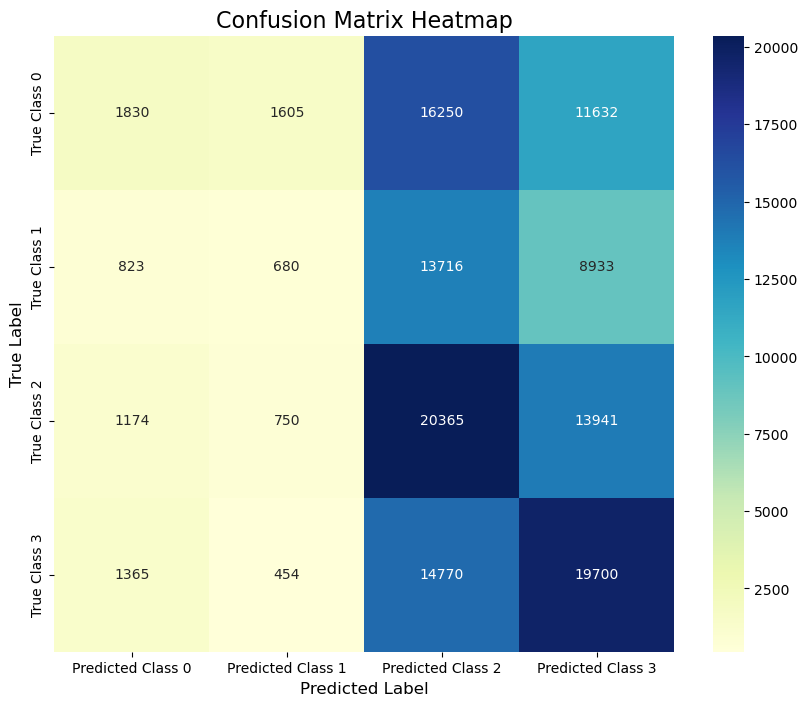

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
test['pred']=y_pred
# Assuming you have a DataFrame 'test_df' with 'Performance_Label' and 'pred' columns
y_true = test['Performance_Label']
y_pred = test['pred']

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Create a DataFrame for better labeling
cm_df = pd.DataFrame(cm, 
                     index=['True Class 0', 'True Class 1', 'True Class 2', 'True Class 3'], 
                     columns=['Predicted Class 0', 'Predicted Class 1', 'Predicted Class 2', 'Predicted Class 3'])

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Create the heatmap
sns.heatmap(cm_df, annot=True, fmt='d', cmap='YlGnBu')

# Set title and labels
plt.title('Confusion Matrix Heatmap', fontsize=16)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)

# Show the plot
plt.show()


**When class 3 is predicted the false positives have a better chance of being in class 2 which is good.  Interesting that the false positives for class 3 have a better chance of being in class 0 than class 1.  This suggests that that strong downs and strong Ups are more similar in X than strong Ups and minor Downs.  This all indicates that the extreme swings are somewhat identifiable, but it is hard to distinguish which way the swing will go.**

**Class 2 has recall above 50%, meaning that of the actual moderate Ups in the data set the model could identify 56% of them.  Still the precision is low.  Of the data points predicted as class 2 only 31% are actually class 2. For the purposes of our stock picker, we would want to see precision over 50%.  This way we would know that if the model chooses a stock it has more of chance of actually being positive than not.**

In [51]:

pred_0=test[test['pred']==0]['Pct_Change_20']
pred_1=test[test['pred']==1]['Pct_Change_20']
pred_3=test[test['pred']==3]['Pct_Change_20']
pred_2=test[test['pred']==2]['Pct_Change_20']
print('Average Percent Change of the observations predicted as class 0', pred_0.mean())
print('Average Percent Change of the observations predicted as class 1', pred_1.mean())
print('Average Percent Change of the observations predicted as class 2', pred_2.mean())
print('Average Percent Change of the observations predicted as class 3', pred_3.mean())

Average Percent Change of the observations predicted as class 0 -0.01114948624113076
Average Percent Change of the observations predicted as class 1 -0.031379579426757065
Average Percent Change of the observations predicted as class 2 0.0018181948669665025
Average Percent Change of the observations predicted as class 3 0.020029091775475596


count    54206.000000
mean         0.020029
std          0.081062
min         -0.632255
25%         -0.025164
50%          0.019876
75%          0.063607
max          1.212598
Name: Pct_Change_20, dtype: float64


<Axes: >

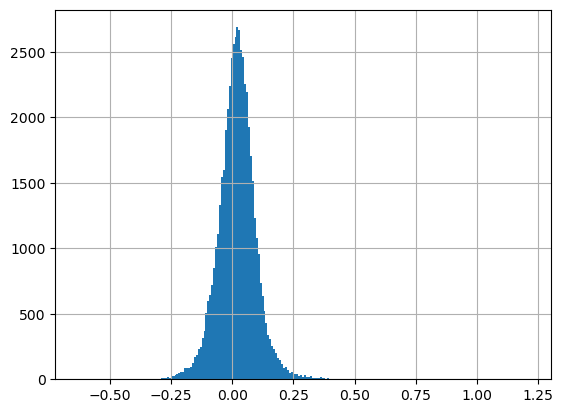

In [53]:
print(pred_3.describe())
pred_3.hist(bins='sqrt')

In [13]:
import pandas as pd
from sklearn.base import BaseEstimator
from sklearn.metrics import confusion_matrix, classification_report

def rolling_stock_classification_multiclass(df, features, target='Performance_Label', initial_train_days=20, predict_days=20,class_=3):
    """
    Performs a rolling fit and prediction on stock data, returning predicted probabilities for each stock and date.

    Args:
        df (pd.DataFrame): The DataFrame containing stock data, including 'Date', 'Ticker', target, and features.
        features (list): A list of column names representing the features to use in the model.
        model (BaseEstimator): The sklearn-compatible model to use for classification.
        target (str): The name of the target column. Default is 'Invest_20'.
        initial_train_days (int): The number of days for initial training. Default is 20.
        predict_days (int): The number of days to predict in each iteration. Default is 20.

    Returns:
        pd.DataFrame: A DataFrame containing Date, Ticker, and predicted probabilities for each stock.
    """
    if not isinstance(df, pd.DataFrame) or df.empty:
        raise ValueError("Input must be a non-empty pandas DataFrame")

    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values(by='Date')
    unique_dates = df['Date'].unique()
    all_predictions = []

    train_end_index = initial_train_days
    while train_end_index < len(unique_dates):
        train_end_date = unique_dates[train_end_index - 1]
        predict_end_index = min(train_end_index + predict_days, len(unique_dates))
        predict_end_date = unique_dates[predict_end_index - 1]

        train_data = df[df['Date'] <= train_end_date]
        test_data = df[(df['Date'] > train_end_date) & (df['Date'] <= predict_end_date)]

        if len(test_data) == 0:
            break


        model, X_test,y_test,y_pred_proba,y_pred=fit_multi_classifier2(train_data,test_data,features, max_depth=3, subsample=0.8, gamma=0.1, n_estimators=400, learning_rate=0.1, colsample_bytree=0.75)



        predictions = pd.DataFrame({
            'Date': test_data['Date'],
            'Ticker': test_data['Ticker'],
            'pred_proba': y_pred_proba[:,class_]
        })
        all_predictions.append(predictions)

        print(f"Predicted from {train_end_date} to {predict_end_date}")
        print(f"Number of predictions: {len(predictions)}")
        print("-" * 30)

        # Move the window forward
        train_end_index = predict_end_index

    final_predictions = pd.concat(all_predictions, ignore_index=True)
    return final_predictions
def fit_multi_classifier2(train,test,features, max_depth=5, subsample=0.8, gamma=0.1, n_estimators=200, learning_rate=0.1, colsample_bytree=0.8):
    X_train, y_train = preprocess_data(train, features)
    X_test, y_test = preprocess_data(test, features)
    class_weights = {0: 1, 1: 1, 2: 1, 3: 1}  # Adjust these values as needed
    model = XGBClassifier(
    max_depth=max_depth,
    n_estimators= n_estimators,
    learning_rate=learning_rate,
    gamma=gamma,
    colsample_bytree=colsample_bytree,
    subsample=subsample,
    
    scale_pos_weight=class_weights[0],  # Focus on Class 0
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

    model.fit(X_train, y_train)
    
    # 3. Make predictions on test set
    y_pred_proba = model.predict_proba(X_test)
    y_pred=model.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    # 5. Feature Importance
    feature_importance = model.feature_importances_
    feature_importance_df = pd.DataFrame({'feature': X_train.columns, 'importance': feature_importance})
    feature_importance_df = feature_importance_df.sort_values('importance', ascending=False).reset_index(drop=True)
    print("\nTop 20 Most Important Features:")
    print(feature_importance_df.head(20))
    return model, X_test,y_test,y_pred_proba,y_pred
def create_performance_label(df, holding_period):
    pct_change_col = f'Pct_Change_{holding_period}'
    #df[pct_change_col] = df.groupby('Ticker')['Close'].pct_change(periods=holding_period).shift(-holding_period)
    
    # Separate positive and negative changes
    positive_changes = df[df[pct_change_col] > 0][pct_change_col]
    negative_changes = df[df[pct_change_col] <= 0][pct_change_col]
    
    # Calculate medians
    positive_median = positive_changes.median()
    negative_median = negative_changes.median()
    
    def categorize(value):
        if pd.isna(value):
            return np.nan
        elif value <= negative_median:
            return 0  # Strong negative
        elif negative_median < value <= 0:
            return 1  # Slight negative
        elif 0 < value < positive_median:
            return 2  # Slight positive
        else:
            return 3  # Strong positive
    
    df['Performance_Label'] = df[pct_change_col].apply(categorize)
    return df




In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import stock_project_functions_SAVE as spf
import model_functions_SAVE as mf
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,matthews_corrcoef
with open('rolling_class_report.txt', 'r') as file:
    content = file.read()
    print(content)

rerun=False
keep_features=P_test[P_test['importance']>0]['feature']

df_2022=pd.read_csv('All_Stock_Data_TTM_RS_2022-2024.csv')
df_2022=create_performance_label(df_2022,20)
if rerun:
    
    df_2022.dropna(subset=['Performance_Label'],inplace=True)
    df_2022.dropna(inplace=True)
    df_2022['Date']=pd.to_datetime(df_2022['Date'])
    results_24=rolling_stock_classification_multiclass(df_2022, keep_features,class_=3)
    results_24.to_csv('Rolling_Fit_Mulit_Class_2022-2024_results.csv',index=False)
else:
    results_24=pd.read_csv('Rolling_Fit_Mulit_Class_2022-2024_results.csv')
results_24


Accuracy: 0.26804347826086955

Classification Report:
              precision    recall  f1-score   support

           0       0.24      0.04      0.07      2511
           1       0.29      0.43      0.35      2413
           2       0.24      0.47      0.32      2259
           3       0.30      0.13      0.18      2017

    accuracy                           0.27      9200
   macro avg       0.27      0.27      0.23      9200
weighted avg       0.27      0.27      0.23      9200


Confusion Matrix:
[[ 107  867 1293  244]
 [  83 1029 1101  200]
 [ 120  887 1061  191]
 [ 128  739  881  269]]

Top 20 Most Important Features:
                       feature  importance
0    Vix_Close_pct_change_lag0    0.014338
1    VOO_Close_pct_change_lag0    0.011801
2            Squeeze_On_Lag_16    0.010911
3       TTM_Weekly_change_lag4    0.010592
4            Is_Local_Max_lag8    0.010052
5   VOO_Close_pct_change_lag11    0.009455
6            Squeeze_On_Lag_17    0.009186
7    VOO_Close_pct_cha

,Date,Ticker,pred_proba
0,2021-08-30,NEE,0.112296
1,2021-08-30,NFLX,0.391551
2,2021-08-30,NI,0.265826
3,2021-08-30,NKE,0.005030
4,2021-08-30,NTAP,0.269567
...,...,...,...
330778,2024-07-05,EL,0.324259
330779,2024-07-05,EIX,0.162930
330780,2024-07-05,EG,0.205958
330781,2024-07-05,ERIE,0.196071


In [23]:
df_2022['Pct_Change_20'].describe()

count    388763.000000
mean          0.009816
std           0.086123
min          -0.622085
25%          -0.041787
50%           0.008562
75%           0.058802
max           2.223735
Name: Pct_Change_20, dtype: float64

In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,matthews_corrcoef
df_2022=create_performance_label(df_2022,20)
to_join=df_2022[['Pct_Change_20','Invest_20','Date','Ticker','Performance_Label']]
to_join['Date']=pd.to_datetime(to_join['Date'])
results_24['Date']=pd.to_datetime(results_24['Date'])
rolling_fit_24=pd.merge(to_join,results_24,on=['Date','Ticker'])
rolling_fit_24['pred']=(rolling_fit_24['pred_proba']>0.5)


In [35]:
etf_df_24=pd.read_csv('All_ETF_Data_TTM_RS_2022-2024.csv')
keep_features_etf=P_test_etf[P_test_etf['importance']>0]['feature'].values
etf_df_24=create_performance_label(etf_df_24,20)
etf_df_24.dropna(inplace=True)
etf_df_24['Date']=pd.to_datetime(etf_df_24['Date'])
results_24_etf=rolling_stock_classification_multiclass(etf_df_24, keep_features_etf,class_=3)

Accuracy: 0.4818181818181818

Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.14      0.20        21
           1       0.38      0.04      0.07        73
           2       0.52      0.93      0.67       104
           3       0.19      0.14      0.16        22

    accuracy                           0.48       220
   macro avg       0.35      0.31      0.27       220
weighted avg       0.42      0.48      0.37       220


Confusion Matrix:
[[ 3  5 11  2]
 [ 2  3 62  6]
 [ 2  0 97  5]
 [ 2  0 17  3]]

Top 20 Most Important Features:
                       feature  importance
0              VWAP_DIFF_lag16    0.035434
1              VWAP_DIFF_lag14    0.029008
2            Squeeze_On_Lag_25    0.023111
3                TTM_raw_lag14    0.019911
4                TTM_raw_lag18    0.018634
5           Is_Local_Max_lag29    0.016689
6                TTM_raw_lag23    0.015407
7               VWAP_DIFF_lag0    0.014847
8          T

In [41]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,matthews_corrcoef
to_join=etf_df_24[['Pct_Change_20','Invest_20','Date','Ticker','Performance_Label']]
to_join['Date']=pd.to_datetime(to_join['Date'])
results_24_etf['Date']=pd.to_datetime(results_24_etf['Date'])
rolling_fit_24_etf=pd.merge(to_join,results_24_etf,on=['Date','Ticker'])




In [43]:
def make_date(df):
    df['Date']=pd.to_datetime(df['Date'])
    return df
rolling_fit_24=make_date(rolling_fit_24)
rilling_fit_24_etf=make_date(rolling_fit_24_etf)

In [45]:
final_df=get_final_stock_data(rolling_fit_24, rolling_fit_24_etf)

In [ ]:
df_2022=pd.read_csv('All_Stock_Data_TTM_RS_2022-2024.csv')
df_2022=make_date(df_2022)
to_join=df_2022[['Pct_Change_20','Date','Ticker']]
final_df=pd.merge(final_df,to_join, left_on=['End Date','Stock'], right_on=['Date','Ticker'])

In [53]:
final_df.head(10)

,End Date,Metric,Industry,Stock,Stock_Rank,Industry_Rank,Stock_Metric_Sign,Percent Gain,pred_proba_etf,pred_proba_stock
2,2021-08-30,Predict_From_Model,XLE,MRO,1.0,1.0,True,0.170068,0.780546,0.866026
0,2021-08-30,Predict_From_Model,XLE,BKR,2.0,1.0,True,0.092983,0.780546,0.817655
1,2021-08-30,Predict_From_Model,XLE,HAL,3.0,1.0,True,0.113100,0.780546,0.753092
4,2021-08-31,Predict_From_Model,XLE,MRO,1.0,1.0,True,0.173617,0.741677,0.874347
3,2021-08-31,Predict_From_Model,XLE,COP,2.0,1.0,True,0.225283,0.741677,0.833427
5,2021-08-31,Predict_From_Model,XLE,OXY,3.0,1.0,True,0.169407,0.741677,0.825141
6,2021-09-01,Predict_From_Model,XLE,EQT,1.0,1.0,True,0.091200,0.844635,0.757846
8,2021-09-01,Predict_From_Model,XLE,MRO,2.0,1.0,True,0.214032,0.844635,0.733088
7,2021-09-01,Predict_From_Model,XLE,MPC,3.0,1.0,True,0.079651,0.844635,0.715882
11,2021-09-02,Predict_From_Model,XLE,MRO,1.0,1.0,True,0.215017,0.712824,0.834470


In [55]:
final_df['Industry_Rank'].value_counts()

Industry_Rank
1.0    1206
2.0     825
3.0     477
Name: count, dtype: int64

In [77]:
final_df.to_csv('Stock_Data_20_1_20_predict_from_model_multiclass_2022-2024.csv', index=False)

In [71]:
D=pd.read_csv('stock_data_details.csv')
D
new={'File_Name':['Stock_Data_20_1_20_predict_from_model_multiclass_2022-2024.csv'],
     'Back_Period':[20],
     'Invest_Period':[1],
     'Holding_Period':[20],
     'Strategy': ['predict_from_model_multiclass'],
     'Time_Period':['2022-2024'],
     'Stock_Subset':['All Stocks'],
     'Other_Specification':['Predicted the highest percent changes using rolling fit multiclass'],
    
     'Number_Of_Stocks': [len(final_df['Stock'].unique())],
     'Variable_Name': ['df_one_twenty24_xg_rolling_multi']
    }
new_df=pd.DataFrame(new)
final_D=pd.concat([D,new_df])
final_D.to_csv('stock_data_details.csv')